# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


In [6]:
df = df.drop(columns=['t','sensor0','sensor1'])
df.head()

KeyError: "['t' 'sensor0' 'sensor1'] not found in axis"

In [8]:
print(df.columns)
df.shape

Index(['x', 'y', 'z', 'layer_id', 'temp', 'track_id', 'track_orient',
       'pos_rel', 't_rel'],
      dtype='object')


(4512006, 9)

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def compute_global_t2_from_long_df(df, n_components=0.90):
    # Step 1: Pivot the data (one row per track_id, one column per pos_rel)
    df_pivot = df.pivot_table(index='track_id', columns='pos_rel', values='temp')

    # Step 2: Drop rows with any missing values (incomplete tracks)
    df_pivot = df_pivot.dropna()

    # Step 3: Map layer_id for each track_id
    layer_map = df.drop_duplicates('track_id')[['track_id', 'layer_id']].set_index('track_id')
    valid_track_ids = df_pivot.index
    layer_ids = layer_map.loc[valid_track_ids, 'layer_id'].values

    # Step 4: Perform global PCA
    X = df_pivot.values
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    std_devs = np.sqrt(pca.explained_variance_)

    # Step 5: Compute Hotelling T² for each track
    T2 = np.sum((X_pca / std_devs) ** 2, axis=1)

    # Step 6: Return DataFrame
    result_df = pd.DataFrame({
        'T2': T2,
        'track_id': df_pivot.index,
        'layer_id': layer_ids
    })

    return result_df

df_result = compute_global_t2_from_long_df(df)
print(df_result.head())

ValueError: Found array with 0 sample(s) (shape=(0, 1209725)) while a minimum of 1 is required by PCA.

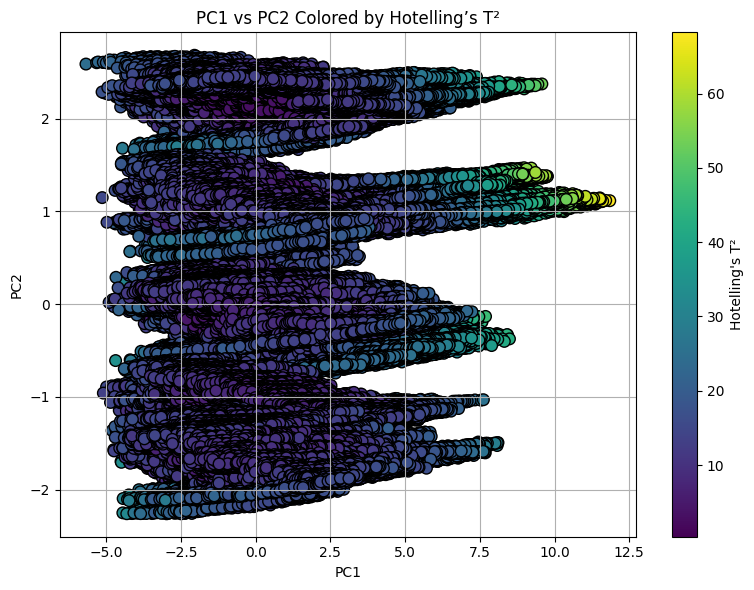

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Step 2: Apply PCA to retain 90% of the variance
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Compute Hotelling's T²
eigenvalues = pca.explained_variance_
T2 = np.sum((X_pca**2) / eigenvalues, axis=1)

# Step 4: Plot PC1 vs PC2 colored by T²
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=T2, cmap='viridis', edgecolor='k', s=70)
plt.colorbar(scatter, label="Hotelling's T²")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2 Colored by Hotelling’s T²')
plt.grid(True)
plt.tight_layout()
plt.show()


# References
* [In-Process Monitoring of Selective Laser Melting: Spatial Detection of Defects Via Image Data Analysis](https://re.public.polimi.it/bitstream/11311/1016879/6/in-process%20monitoring%20of%20slm.pdf)

# Further improvements

* cambiare dinamicamente il numero di cluster con l'elbow plot, mi aspetto 2/3 cluster sono ottimi
* non usare la PCA e avere 25 datapoints nel CC
* fare plot di Hotelling T2 come nel paper, magari 3d plot [esempio](https://learnche.org/pid/latent-variable-modelling/principal-component-analysis/hotellings-t2-statistic)